In [1]:
import os
import sys
import csv
import textwrap
import warnings

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from src.utils.checkpoint import load_params, load_variational

from src.model.functions import new_user_base, new_user_var

warnings.simplefilter("ignore")

#### Load Embeddings

In [2]:
params = load_params("../artifacts/model/32m_users_training_feat_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [3]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [4]:
params = load_params("../artifacts/model/32m_users_training_10.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

In [5]:
params = load_params("../artifacts/model/32m_users_training_feat_10.npz")
user_bias_with_f = params["user_bias"]
movie_bias_with_f = params["movie_bias"]
user_embeddings_with_f = params["user_embedding"]
movie_embeddings_with_f = params["movie_embedding"]

In [6]:
params = load_variational("../artifacts/model/32m_variational_10.npz")
user_mean_bias = params["user_mean_bias"]
movie_mean_bias = params["movie_mean_bias"]
user_mean_embedding = params["user_mean_embedding"]
movie_mean_embedding = params["movie_mean_embedding"]
user_var_bias = params["user_var_bias"]
movie_var_bias = params["movie_var_bias"]
user_var_embedding = params["user_var_embedding"]
movie_var_embedding = params["movie_var_embedding"]

#### Load Data

In [7]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}
movie_id_to_genres = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, genres = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id
        movie_id_to_genres[movie_id] = genres

#### Movie Embedding Space

In [8]:
idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

In [9]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings" in idx_to_title[x].lower())
            or ("fifty shades" in idx_to_title[x].lower())
            or ("despicable me" in idx_to_title[x].lower())
            or ("hotel transylvania" in idx_to_title[x].lower())
        ),
        range(len(movie_bias))
    )
)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


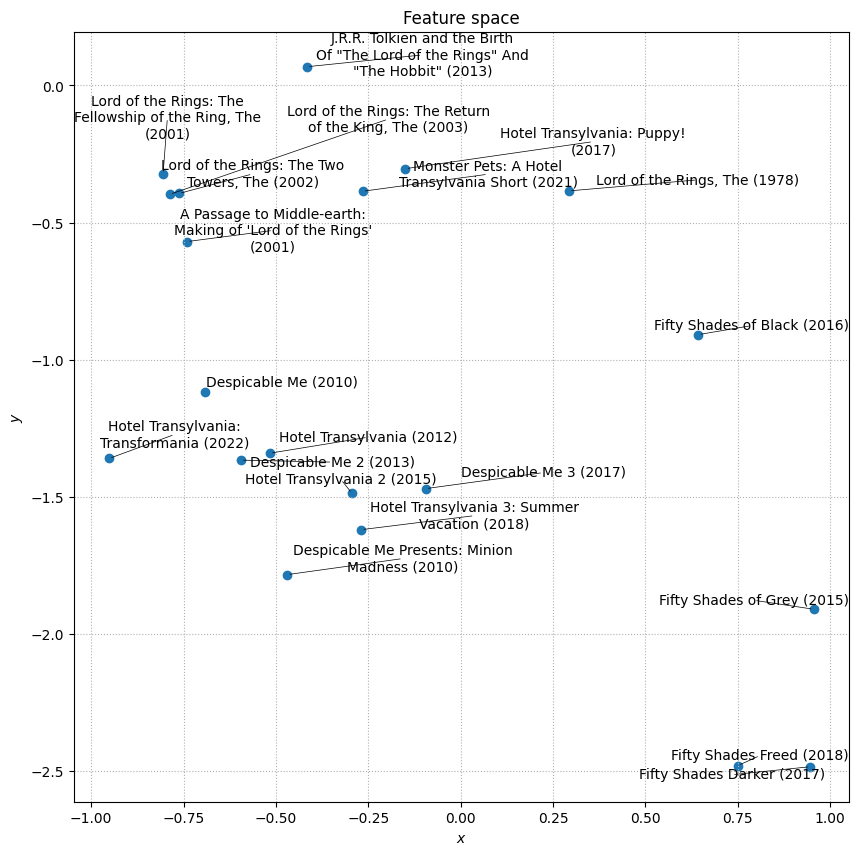

In [10]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Feature Embedding Space

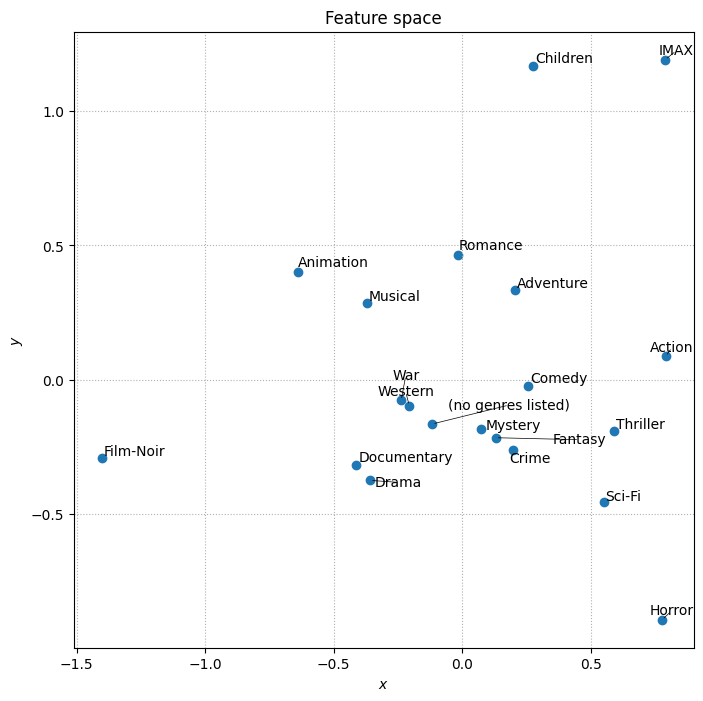

In [11]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Dummy User Embedding

In [12]:
lord_of_the_ring_title = "Lord of the Rings: The Fellowship of the Ring, The (2001)"
lord_of_the_ring_id = title_to_movie_id[lord_of_the_ring_title]
lord_of_the_ring_rating = 5.0
lord_of_the_ring_idx = movie_id_to_idx[lord_of_the_ring_id]

print(f"Movie: {lord_of_the_ring_title}")
print(f"Degree: {len(movie_user[lord_of_the_ring_idx][0])}")
print(f"Genres: {movie_id_to_genres[lord_of_the_ring_id]}")

Movie: Lord of the Rings: The Fellowship of the Ring, The (2001)
Degree: 73122
Genres: Adventure|Fantasy


In [13]:
dummy_embedding, _ = new_user_base(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_embeddings,
    movie_bias,
    r_lambda,
    r_gamma,
    r_tau,
)

dummy_embedding_f, _ = new_user_base(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_embeddings_with_f,
    movie_bias_with_f,
    r_lambda,
    r_gamma,
    r_tau,
)

dummy_embedding_v, _, _, _ = new_user_var(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_mean_embedding,
    movie_var_embedding,
    movie_mean_bias,
    r_lambda,
    r_gamma,
    r_tau,
)

#### Top 10 Prediction for Dummy User

In [14]:
movie_scores = movie_embeddings @ dummy_embedding[0] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Queen of the Mountains (2014)  - degree: 0  - genres: Action|Drama
2 - Escape to Burma (1955)  - degree: 1  - genres: Adventure
3 - Death at Love House (1976)  - degree: 1  - genres: Horror|Mystery
4 - Jeremy Scott: The People's Designer (2015)  - degree: 1  - genres: Documentary
5 - The Signal (2015)  - degree: 1  - genres: (no genres listed)
6 - The Farmer and the Belle: Saving Santaland (2020)  - degree: 1  - genres: Children|Comedy|Romance
7 - Millhouse (1971)  - degree: 2  - genres: (no genres listed)
8 - Born to Ride (1991)  - degree: 0  - genres: Action
9 - 121: Overcoming Drug Addiction by Faith (2021)  - degree: 1  - genres: Documentary
10 - Weary River (1929)  - degree: 1  - genres: Drama|Romance


In [15]:
movie_scores = movie_embeddings @ dummy_embedding[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - Queen of the Mountains (2014)  - degree: 0  - genres: Action|Drama
2 - Tuning In (2008)  - degree: 1  - genres: Documentary
3 - Surviving Family (2014)  - degree: 1  - genres: Drama|Romance
4 - Encounters in the Deep (1979)  - degree: 1  - genres: Sci-Fi
5 - Alan dies at the end of the movie (2007)  - degree: 0  - genres: Thriller
6 - Long Live the Bride and Groom (1970)  - degree: 1  - genres: Comedy
7 - Swanee River (1939)  - degree: 0  - genres: Drama|Thriller
8 - Letters of a Novice (1960)  - degree: 1  - genres: Drama
9 - The Other Side of the Underneath (1972)  - degree: 1  - genres: Drama|Horror
10 - Murder in the Private Car (1934)  - degree: 0  - genres: Mystery|Romance


In [16]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_embeddings @ dummy_embedding[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Housekeeping (1987)  - degree: 240  - genres: Comedy|Drama
2 - Happy Times (Xingfu shiguang) (2000)  - degree: 106  - genres: Comedy|Drama
3 - Autumn Afternoon, An (Sanma no aji) (1962)  - degree: 190  - genres: Drama
4 - West of Memphis (2012)  - degree: 196  - genres: Documentary
5 - Moxie (2021)  - degree: 110  - genres: Comedy|Drama
6 - Mr. Jealousy (1997)  - degree: 272  - genres: Comedy|Romance
7 - Barbara (2012)  - degree: 178  - genres: Drama
8 - Silent Light (Stellet licht) (2007)  - degree: 102  - genres: Drama
9 - Taste of Tea, The (Cha no aji) (2004)  - degree: 170  - genres: Comedy|Drama
10 - Dheepan (2015)  - degree: 163  - genres: Drama


#### Top 10 Prediction for Dummy User [with features]

In [17]:
movie_scores = movie_embeddings_with_f @ dummy_embedding_f[0] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Ullathai Allitha (1996)  - degree: 1  - genres: Comedy|Drama|Romance
2 - In the Aftermath (1989)  - degree: 0  - genres: (no genres listed)
3 - Christmas Crash (2009)  - degree: 1  - genres: Drama
4 - Long Distance (2005)  - degree: 0  - genres: Horror|Thriller
5 - Ubalda, All Naked and Warm (1972)  - degree: 0  - genres: Comedy
6 - Born to Ride (1991)  - degree: 0  - genres: Action
7 - Tribulation (2000)  - degree: 0  - genres: Drama|Sci-Fi|Thriller
8 - Radical Grace (2015)  - degree: 1  - genres: Documentary
9 - Atlanta’s Olympic Glory (1997)  - degree: 0  - genres: Documentary
10 - The Castro's Abbess (1974)  - degree: 0  - genres: (no genres listed)


In [18]:
movie_scores = movie_embeddings_with_f @ dummy_embedding_f[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - In the Aftermath (1989)  - degree: 0  - genres: (no genres listed)
2 - Ullathai Allitha (1996)  - degree: 1  - genres: Comedy|Drama|Romance
3 - Tadpole and the Whale (1987)  - degree: 0  - genres: Adventure|Children
4 - Ubalda, All Naked and Warm (1972)  - degree: 0  - genres: Comedy
5 - The Flirting Widow (1930)  - degree: 0  - genres: (no genres listed)
6 - Radical Grace (2015)  - degree: 1  - genres: Documentary
7 - Time Lapse (2001)  - degree: 1  - genres: Action|Thriller
8 - The Lone Wolf in London (1947)  - degree: 0  - genres: Action|Comedy|Crime|Mystery
9 - Blanka (2015)  - degree: 2  - genres: Drama
10 - Atlanta’s Olympic Glory (1997)  - degree: 0  - genres: Documentary


In [19]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_embeddings_with_f @ dummy_embedding_f[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122  - genres: Adventure|Fantasy
4 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
5 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
6 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
7 - Star Wars: Episode II - Attack of the Clones (2002)  - degree: 27415  - genres: Action|Adventure|Sci-Fi|IMAX
8 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
9 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496  - genres: Action|A

#### Top 10 Prediction for Dummy User [Variational]

In [20]:
movie_scores = movie_mean_embedding @ dummy_embedding_v[0] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Queen of the Mountains (2014)  - degree: 0  - genres: Action|Drama
2 - Weary River (1929)  - degree: 1  - genres: Drama|Romance
3 - Escape to Burma (1955)  - degree: 1  - genres: Adventure
4 - Christmas Song (2014)  - degree: 1  - genres: Children|Romance
5 - 121: Overcoming Drug Addiction by Faith (2021)  - degree: 1  - genres: Documentary
6 - After the Promise (1987)  - degree: 2  - genres: (no genres listed)
7 - Death at Love House (1976)  - degree: 1  - genres: Horror|Mystery
8 - Jeremy Scott: The People's Designer (2015)  - degree: 1  - genres: Documentary
9 - Mother is a Freshman (1949)  - degree: 0  - genres: Comedy
10 - Millhouse (1971)  - degree: 2  - genres: (no genres listed)


In [21]:
movie_scores = movie_mean_embedding @ dummy_embedding_v[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - The Outlaw Stallion (1954)  - degree: 0  - genres: (no genres listed)
2 - Tarzan, the Ape Man (1959)  - degree: 0  - genres: Action|Adventure
3 - A Girl of the Limberlost (1990)  - degree: 1  - genres: Drama
4 - Akallinen mies (1986)  - degree: 1  - genres: (no genres listed)
5 - Toy Masters (2014)  - degree: 0  - genres: Documentary
6 - Eggshells (1969)  - degree: 3  - genres: Drama|Fantasy
7 - Return to Boggy Creek (1977)  - degree: 1  - genres: Adventure|Children
8 - Expensive Husbands (1937)  - degree: 0  - genres: Comedy|Musical|Romance
9 - Tagget (1991)  - degree: 0  - genres: Crime|Thriller
10 - Paradise girls (2005)  - degree: 1  - genres: (no genres listed)


In [22]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_mean_embedding @ dummy_embedding_v[0] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122  - genres: Adventure|Fantasy
4 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
5 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151  - genres: Action|Adventure|Sci-Fi
6 - Star Wars: Episode IV - A New Hope (1977)  - degree: 85010  - genres: Action|Adventure|Sci-Fi
7 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496  - genres: Action|Adventure|Sci-Fi
8 - Star Wars: Episode II - Attack of the Clones (2002)  - degree: 27415  - genres: Action|Adventure|Sci-Fi|IMAX
9 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genr

#### Top Polarizing Movies

In [23]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm")

for i, idx in enumerate(reversed(movie_embedding_norm[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 20 Movie by embedding norm
1 - Moses Storm: Trash White (2022)  - degree: 2
2 - Charley Moon (1956)  - degree: 0
3 - Bendito Machine IV: Fuel the Machines (2012)  - degree: 0
4 - Denver and Rio Grande (1952)  - degree: 1
5 - Schoßgebete (2014)  - degree: 0
6 - Purchè finisca bene - Se mi lasci ti sposo  - degree: 1
7 - Crime and Punishment (1956)  - degree: 1
8 - Tokyo Ghoul 'S' (2019)  - degree: 2
9 - Processo alla città (1952)  - degree: 1
10 - Douche (2018)  - degree: 1
11 - Hidden Orchard Mysteries: The Case of the Air B and B Robbery (2020)  - degree: 1
12 - Super Daughter-in-Law (2008)  - degree: 1
13 - Funeralopolis : A Suburban Portrait (2017)  - degree: 1
14 - Demonicus (2001)  - degree: 0
15 - Second Wind (1976)  - degree: 0
16 - I'll Wait for You (1941)  - degree: 0
17 - Swanee River (1939)  - degree: 0
18 - Compound Fracture (2013)  - degree: 1
19 - Bet Your Life (2004)  - degree: 1
20 - Writer's Block (2019)  - degree: 1


In [24]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm [< 100 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 20 Movie by embedding norm [< 100 rating filtering]
1 - Dumb & Dumber (Dumb and Dumber) (1994)  - degree: 36802
2 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151
3 - Star Wars: Episode IV - A New Hope (1977)  - degree: 85010
4 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449
5 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122
6 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463
7 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496
8 - Ace Ventura: Pet Detective (1994)  - degree: 42728
9 - Harry Potter and the Deathly Hallows: Part 2 (2011)  - degree: 20227
10 - Harry Potter and the Deathly Hallows: Part 1 (2010)  - degree: 20969
11 - Harry Potter and the Half-Blood Prince (2009)  - degree: 21033
12 - Harry Potter and the Order of the Phoenix (2007)  - degree: 21073
13 - Harry Potter and the Prisoner of Azkaban (2004)  - degree: 31427
14 - Star Wars: Episode III - Revenge of th

In [25]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Top 20 Movie by embedding norm [cosine similarity filtering + < 100 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break  
    if idx in filtering:
        continue
        
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Top 20 Movie by embedding norm [cosine similarity filtering + < 100 rating filtering]
1 - Dumb & Dumber (Dumb and Dumber) (1994)  - degree: 36802
2 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151
3 - Harry Potter and the Deathly Hallows: Part 2 (2011)  - degree: 20227
4 - Blair Witch Project, The (1999)  - degree: 22780
5 - Titanic (1997)  - degree: 45767
6 - Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)  - degree: 19566
7 - Avengers: Infinity War - Part II (2019)  - degree: 11811
8 - Rocky (1976)  - degree: 20682
9 - Saw (2004)  - degree: 12829
10 - Toy Story 2 (1999)  - degree: 32683
11 - Dark Knight Rises, The (2012)  - degree: 30369
12 - Room, The (2003)  - degree: 1179
13 - Exorcist, The (1973)  - degree: 18245
14 - Back to the Future Part III (1990)  - degree: 26166
15 - Twilight (2008)  - degree: 8882
16 - American Pie 2 (2001)  - degree: 13139
17 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175


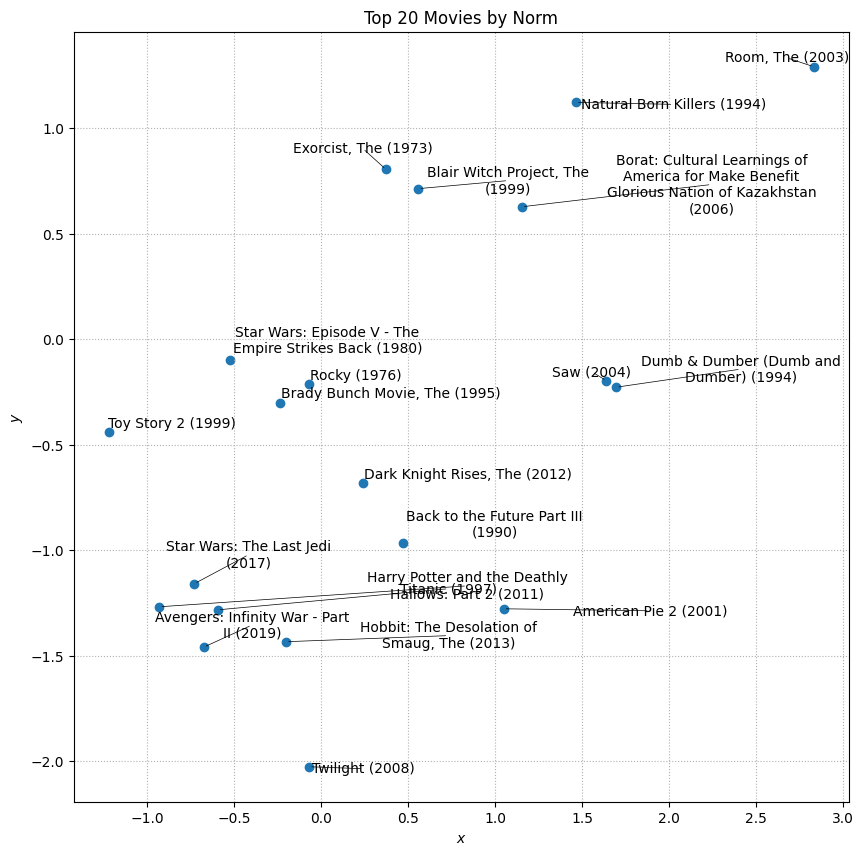

In [26]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Top 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/top_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Less Polarizing Movies

In [27]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm")

for i, idx in enumerate(movie_embedding_norm[:20]):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Bottom 20 Movie by embedding norm
1 - Losing It (2006)  - degree: 1
2 - Act of God (2009)  - degree: 1
3 - The Milkmaid (1953)  - degree: 1
4 - Sherlock Holmes: The Eligible Bachelor (1993)  - degree: 2
5 - Sherlock: Case of Evil (2002)  - degree: 2
6 - The Last Producer (2000)  - degree: 1
7 - Hard Time (1998)  - degree: 1
8 - Any And Every Which Way (2010)  - degree: 2
9 - What Happened On New Year's Eve (2022)  - degree: 2
10 - L'Homme Machine (1885)  - degree: 1
11 - Voices (1979)  - degree: 1
12 - Signal 100 (2019)  - degree: 1
13 - 72 Tenants of Prosperity (2010)  - degree: 2
14 - Pictures from Life's Other Side (1971)  - degree: 1
15 - UFOs: The Secret History (2010)  - degree: 2
16 - Explant (2021)  - degree: 1
17 - Richard Attenborough: A Life in Film (2014)  - degree: 1
18 - Bachelor Flat (1962)  - degree: 1
19 - Noi donne siamo fatte così (1971)  - degree: 1
20 - Clarence, the Cross-Eyed Lion (1965)  - degree: 2


In [28]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm [< 100 rating filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Bottom 20 Movie by embedding norm [< 100 rating filtering]
1 - Border, The (1982)  - degree: 108
2 - Where the Sidewalk Ends (1950)  - degree: 101
3 - Bobby Fischer Against the World (2011)  - degree: 172
4 - Dead End (1937)  - degree: 122
5 - Shiri (Swiri) (1999)  - degree: 176
6 - Just Another Love Story (Kærlighed på film) (2007)  - degree: 101
7 - Senior Year (2022)  - degree: 100
8 - Soft Skin, The (La peau douce) (1964)  - degree: 100
9 - Ballad of Cable Hogue, The (1970)  - degree: 206
10 - Horde, The (La Horde) (2009)  - degree: 111
11 - White Material (2009)  - degree: 118
12 - Black Sunday (1977)  - degree: 209
13 - Stillwater (2021)  - degree: 155
14 - Main Hoon Na (2004)  - degree: 106
15 - Kansas City Confidential (1952)  - degree: 108
16 - Bow, The (Hwal) (2005)  - degree: 112
17 - Michael Jackson's Thriller (1983)  - degree: 114
18 - The Hummingbird Project (2018)  - degree: 126
19 - Fatman (2020)  - degree: 148
20 - Married Life (2007)  - degree: 126


In [29]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Bottom 20 Movie by embedding norm [cosine similarity filtering + <100 ratings filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break 
    if idx in filtering:
        continue

    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Bottom 20 Movie by embedding norm [cosine similarity filtering + <100 ratings filtering]
1 - Border, The (1982)  - degree: 108
2 - Where the Sidewalk Ends (1950)  - degree: 101
3 - Bobby Fischer Against the World (2011)  - degree: 172
4 - Dead End (1937)  - degree: 122
5 - Shiri (Swiri) (1999)  - degree: 176
6 - Just Another Love Story (Kærlighed på film) (2007)  - degree: 101
7 - Senior Year (2022)  - degree: 100
8 - Soft Skin, The (La peau douce) (1964)  - degree: 100
9 - Ballad of Cable Hogue, The (1970)  - degree: 206
10 - Horde, The (La Horde) (2009)  - degree: 111
11 - White Material (2009)  - degree: 118
12 - Black Sunday (1977)  - degree: 209
13 - Stillwater (2021)  - degree: 155
14 - Main Hoon Na (2004)  - degree: 106
15 - Kansas City Confidential (1952)  - degree: 108
16 - Bow, The (Hwal) (2005)  - degree: 112
17 - Michael Jackson's Thriller (1983)  - degree: 114
18 - The Hummingbird Project (2018)  - degree: 126
19 - Fatman (2020)  - degree: 148
20 - Married Life (2007)  - d

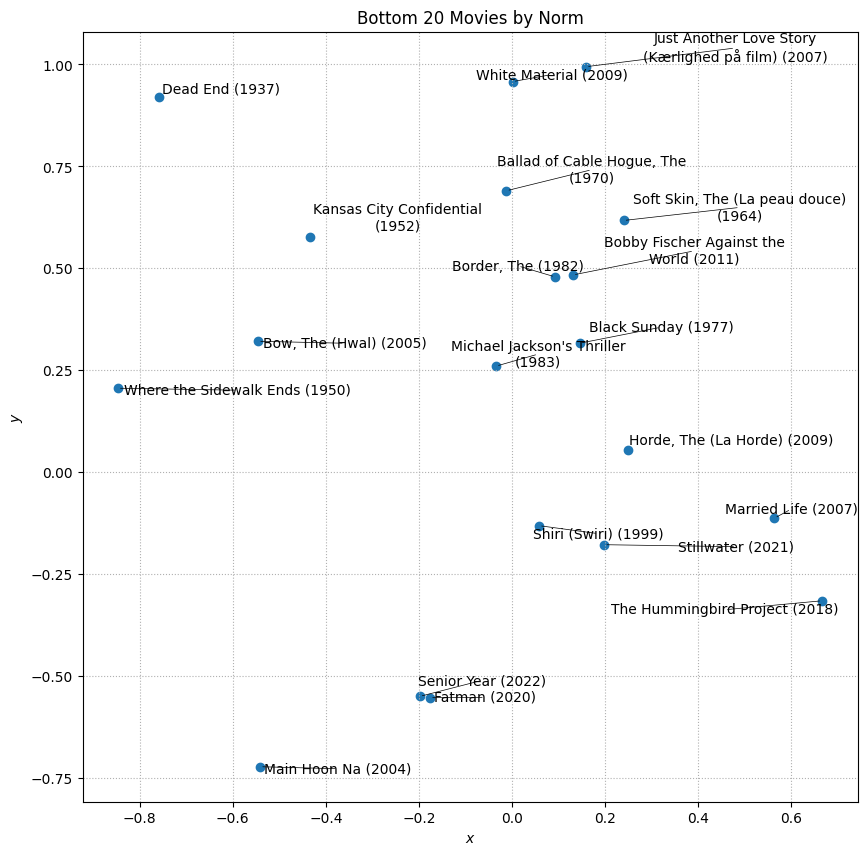

In [30]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Bottom 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/bottom_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

---